# Exercises

These small exercises are intended to build on the knowledge that you acquired in the [first](TV_denoising_with_PDHG.ipynb) [two](Using_a_different_solver.ipynb) notebooks. The exercises do not depend on each other. Feel free to pick those you like and do them in any order.

## General note

The most important technique to solve the exercises is to browse the [ODL examples](https://github.com/odlgroup/odl/tree/master/examples) and "steal" code snippets from there. You will need to make adaptions, of course, but in general you can find a lot of things already done and explained in a comment. However, if the exact problem you're trying to solve is solved in one of the examples, in your own interest **do not just copy the code.**

If you have trouble understanding the explanations, or if there is an error, please [let us know](https://github.com/odlgroup/odl/issues). These examples are meant to be understandable pretty much without prior knowledge, and we appreciate any feedback on them.

## 1. Tomography

Instead of denoising, solve the TV-regularized tomography problem

$$
    \min_{x \geq 0} \left[ \| A x - y \|_2^2 + \alpha \| \nabla x \|_1 \right],
$$

where $A$ is the ray transform. You may pick your favorite acquisition geometry (2D, 3D, paralell beam, cone beam, ...). Use one of the solvers from the first two notebooks.

### Good to know

- Find out how to set up the ray transform as ODL operator. You should use the ASTRA toolbox as backend if possible.
- The data fit $\|\cdot -y\|_2^2$ is now defined on a different space than before, and also $y$ is no longer an element of the reconstruction space $X$. Make sure you understand the details.

## 2. Smooth solvers

ODL also has a number of numerical solvers for smooth problems, most of them first-order methods, i.e., methods that involve the gradient of the cost function. The [LBFGS](https://github.com/odlgroup/odl/blob/ad32a286b69f34260d4428d7282b4058ed2e2603/odl/solvers/smooth/newton.py#L247-L487) method is the limited memory variant of the popular [BFGS algorithm](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) for smooth optimization.

Use it to solve the smoothed variant

$$
    \min_{x} \left[ \| x - y \|_2^2 + \alpha \| \nabla x \|_{1, \epsilon} \right]
$$

of the TV denoising problem, where $\|\cdot\|_{1, \epsilon}$ is the [Huber function](https://en.wikipedia.org/wiki/Huber_loss)

$$
    \|x\|_{1, \epsilon} = \int \left|x(t)\right|_\epsilon\, \mathrm{d} t, \\
    |u|_\epsilon =
    \begin{cases}
        \frac{1}{2\epsilon} |u|_2^2,  & \text{if } |u| \leq \epsilon, \\
        |u| - \frac{\epsilon}{2},     & \text{if } |u| > \epsilon.
    \end{cases}
$$

It is a smoothed variant of the 1-norm that is differentiable everywhere. Here's a plot:

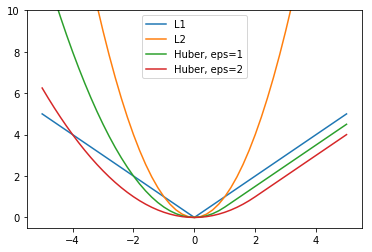

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def huber(t, eps):
    x = np.empty_like(t)
    x[t <= eps] = np.abs(t[t <= eps] ** 2) / (2 * eps)
    x[t > eps] = np.abs(t[t > eps]) - eps / 2
    return x

t = np.linspace(-5, 5, 51)
l1 = np.abs(t)
l2 = np.abs(t) ** 2
huber_1 = huber(t, eps=1)
huber_2 = huber(t, eps=2)

plt.figure()
plt.plot(t, l1, label='L1')
plt.plot(t, l2, label='L2')
plt.plot(t, huber_1, label='Huber, eps=1')
plt.plot(t, huber_2, label='Huber, eps=2')
plt.ylim(-0.5, 10)
plt.legend()
plt.show()

### Good to know

- You may think that this is a lot of work. It isn't! That's because the Huber function is the **Moreau envelope** of the 1-norm. You don't need to know what this means exactly -- the important property that you will apply is

  $$
      \nabla \|\cdot\|_{1, \epsilon}(x) = \frac{1}{\epsilon}\left( x - \mathrm{prox}_{\epsilon \|.\|_1}(x) \right),
  $$
  
  i.e., the gradient can be computed using the proximal operator of the 1-norm. Conveniently, there is the [`odl.solvers.MoreauEnvelope`](https://github.com/odlgroup/odl/blob/ad32a286b69f34260d4428d7282b4058ed2e2603/odl/solvers/functional/default_functionals.py#L2204-L2292) class that implements this property for you (find out how to use it).

- For the smooth solvers, you need to combine everything into a single function, including adding the functions and composing them with linear operators.

## 3. Other goal functions

So far we have considered $\|\cdot -y\|_2^2$ as data fit and $\|\nabla \cdot\|_1$ as regularization term. Both can be changed, of course. 

The 2-norm for the data fit implies the assumption of Gaussian noise in the data, but if the data is actually (pointwise) Poisson-distributed, we should use the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) instead:

$$
    \mathrm{KL}(x; y) = \int \left[ x(t) - y(t) + y(t) \log\left(\frac{y(t)}{x(t)}\right) \right] \mathrm{d} t.
$$

If the data is subject to [salt-and-pepper noise](https://en.wikipedia.org/wiki/Salt-and-pepper_noise), it helps to use the 1-norm as data fit to remove the outliers.

For regularization we can choose, e.g.,

- $\|\cdot\|_1$, leading to a sparse solution (in contrast to a sparse gradient in TV regularization)
- $\|\nabla \cdot\|_2^2$, yielding rather smooth solutions,
- $\|W \cdot\|_1$ with the wavelet decomposition operator $W$,
- ...

Experiment with these alternatives.

## 4. Kaczmarz-type methods (aka ART / SIRT / SART)

Another big class of reconstruction methods is the class of (implicit) least-squares solvers. At convergence, they all solve

$$
    \min_x \|A x - y\|_2^2,
$$

using very different strategies. Prominent examples are [Landweber's method](https://en.wikipedia.org/wiki/Landweber_iteration) (which is nothing but steepest descent for the least-squares problem) and the [conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method).

Kaczmarz-type methods use a strategy of splitting the full problem into blocks of equations, where the splitting is usually done in a way that makes intuitive sense in the context of the problem at hand. For instance, in tomography, single projections or several projections are taken as equation blocks.
In general, the original problem $A x = y$ is rewritten as

$$
    \begin{align}
        A_1 x &= y_1, \\
              &\vdots \\
        A_n x &= y_n
    \end{align}
$$

or more compactly

$$
    \mathbf{A} x = \mathbf{y}, \quad
    \mathbf{A} =
    \begin{pmatrix}
        A_1    \\
        \vdots \\
        A_n
    \end{pmatrix},
    \quad
    \mathbf{y} =
    \begin{pmatrix}
        y_1    \\
        \vdots \\
        y_n
    \end{pmatrix}.
$$

The Kaczmarz method then successively updates $x$ using one block at a time, and repeating the outer loop a given number of times. (The [Wikipedia page](https://en.wikipedia.org/wiki/Kaczmarz_method) explains the basic form of the algorithm.)

Use [`odl.solvers.kaczmarz`](https://github.com/odlgroup/odl/blob/ad32a286b69f34260d4428d7282b4058ed2e2603/odl/solvers/iterative/iterative.py#L387-L517) to solve a tomography problem by splitting along the angles. Experiment a bit with blocking schemes (block-sequential, interlaced, maximizing inter-block angle distance etc.).

### Good to know

- Least-squares methods regularize by *early termination*, i.e., the methods are stopped after $N$ iterations, and this parameter acts as a regularization parameter (larger $N$ means less regularization).
- ODL has convenience functionality to perform the splitting. Given a `Geometry` object for the full problem, you can use indexing like `geometry[i:i+5]` or `geometry[1::2]` to extract sub-geometries.
- SIRT and SART are Kaczmarz's method in spaces with particular weightings.
- To enforce simple constraints like positivity, a projection onto the desired set can be done in each iteration. This runs under the fancy name "Projection onto Convex Sets" (POCS), but usually just means to set all negative values to zero.

## 5. Nonlinear problems

So far we have only considered linear problems. However, sometimes the forward model is actually nonlinear, for instance in propagation-based phase constrast tomography:

$$
    y = \left| Ax + c \right|^2 = F(x)
$$

Here, $A$ is a composition of the ray transform and a Fresnel propagation, and $c$ is a constant (or a function assumed to be known). Further, $x$ is a complex-valued function, i.e., an element of the complex space $L^2(\mathbb{R}^3, \mathbb{C})$.

To solve the problem $F(x) = y$, or a regularized form, e.g.,

$$
    \min_x \left[ \|F(x) - y\|_2^2 + \alpha\|\nabla x\|_1 \right],
$$

we need to know the action of the Jacobian (or *Gâteaux derivative* in functional analysis speak)

$$
    F'(x) v = \lim_{t \to 0} \frac{F(x + t v) - F(x)}{t}.
$$

It appears as part of the gradient of the data fit.

Implement (potentially in a simplified manner) the propagation-based phase contrast forward operator (without linearization) and use a non-linear solver to tackle the problem.

### Good to know

- The Gâteaux derivative is implemented as the `Operator.derivative` method (you should have encountered `Operator` instances by now.
- ODL helps you by automatically applying the chain rule to composed operators, i.e., you only need to implement a custom `derivative` method for your own operator.
- For the nonlinear least-squares problem, we have a bunch of methods that can handle this scenario, like [`odl.solvers.kaczmarz`](https://github.com/odlgroup/odl/blob/ad32a286b69f34260d4428d7282b4058ed2e2603/odl/solvers/iterative/iterative.py#L387-L517) (see above), [`odl.solvers.landweber`](https://github.com/odlgroup/odl/blob/ad32a286b69f34260d4428d7282b4058ed2e2603/odl/solvers/iterative/iterative.py#L26-L116), [`odl.solvers.gauss_newton`](https://github.com/odlgroup/odl/blob/ad32a286b69f34260d4428d7282b4058ed2e2603/odl/solvers/iterative/iterative.py#L305-L384) or [`odl.solvers.conjugate_gradient_nonlinear`](https://github.com/odlgroup/odl/blob/ad32a286b69f34260d4428d7282b4058ed2e2603/odl/solvers/smooth/nonlinear_cg.py#L20-L133).
- On the convex optimization side, all methods that use the gradient of one of the functions can be applied to the nonlinear problem. This includes the [`odl.solvers.forward_backward_pd`](https://github.com/odlgroup/odl/blob/ad32a286b69f34260d4428d7282b4058ed2e2603/odl/solvers/nonsmooth/forward_backward.py#L21-L192) solver and the [proximal gradient](https://github.com/odlgroup/odl/blob/master/odl/solvers/nonsmooth/proximal_gradient_solvers.py) variants (aka ISTA and FISTA). Also the [PDHG method](https://github.com/odlgroup/odl/blob/ad32a286b69f34260d4428d7282b4058ed2e2603/odl/solvers/nonsmooth/primal_dual_hybrid_gradient.py#L29-L303) is implemented for nonlinear operators, although the documentation says otherwise.
- Some of the required functionality is implemented on [a branch](https://github.com/kohr-h/odl/tree/phase_contrast), you can pick code from there.